In [1]:
import os
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, Model

In [3]:
# Load Dataset with improved error handling
def load_dataset(image_dir):
    """Load images and labels from the specified directory."""
    images = []
    labels = []
    if not os.path.exists(image_dir):
        raise ValueError(f"The directory {image_dir} does not exist.")

    for folder_name in os.listdir(image_dir):
        folder_path = os.path.join(image_dir, folder_name)
        if os.path.isdir(folder_path):
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                try:
                    image = cv2.imread(image_path)
                    if image is not None:
                        # Resize image to 224x224 as required by ResNet50
                        image = cv2.resize(image, (224, 224))
                        images.append(image)
                        labels.append(folder_name)
                    else:
                        print(f"Warning: Image at {image_path} could not be loaded.")
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")
        else:
            print(f"Warning: {folder_path} is not a directory.")
    
    if len(images) == 0:
        raise ValueError("No images were loaded.")
        
    return np.array(images), np.array(labels)

# Load and preprocess data
image_dir = "../cowImages"
X, y = load_dataset(image_dir)

print(f"Loaded {len(X)} images from the dataset.")
print(f"Class labels: {set(y)}")

Loaded 1960 images from the dataset.
Class labels: {'lumpycows', 'healthycows'}


Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/49 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7264 - loss: 0.6528 - val_accuracy: 0.8367 - val_loss: 0.3602
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.8343 - loss: 0.3807 - val_accuracy: 0.8673 - val_loss: 0.3247
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8614 - loss: 0.3266 - val_accuracy: 0.8827 - val_loss: 0.3157
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.8595 - loss: 0.3358 - val_accuracy: 0.8699 - val_loss: 0.3251
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8759 - loss: 0.2888 - val_accuracy: 0.8801 - val_loss: 0.3092
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9028 - loss: 0.2542 - val_accuracy: 0.8878 - val_loss: 0.3208
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8847 - loss: 0.2720 - val_accuracy: 0.8878 - val_loss: 0.3467
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8830 - loss: 0.2916 - val_accuracy: 0.8571 - val_loss: 0.3255
Epo

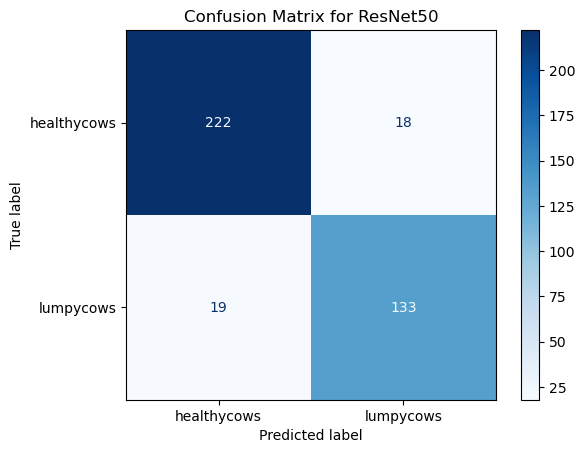

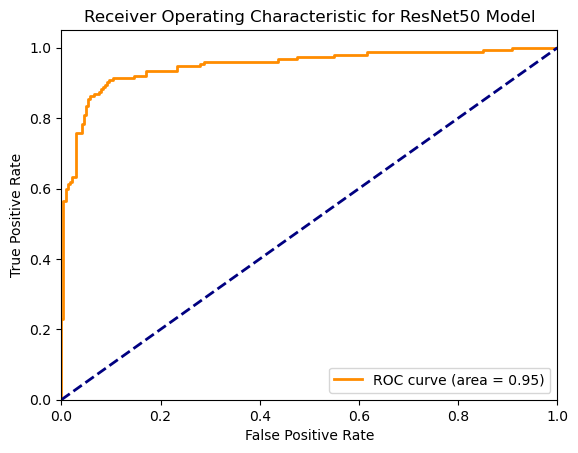

In [21]:
# Function to display sample images with annotations
def display_sample_images(images, labels, label_encoder, num_samples=5):
    plt.figure(figsize=(12, 12))
    indices = np.random.choice(range(len(images)), num_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Class: {label_encoder.inverse_transform([labels[idx]])[0]}")
        plt.axis('off')
    plt.show()

# Function to plot training & validation accuracy and loss over epochs
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Function to visualize feature maps of the first convolutional layers
def visualize_feature_maps(model, image):
    layer_outputs = [layer.output for layer in model.layers[:8]]  # First 8 layers
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    image = preprocess_input(image.reshape(1, 224, 224, 3))  # Adjust if needed
    activations = activation_model.predict(image)
    
    for i, layer_activation in enumerate(activations):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // 16
        display_grid = np.zeros((size * n_cols, 16 * size))
        
        for col in range(n_cols):
            for row in range(16):
                channel_image = layer_activation[0, :, :, col * 16 + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size: (col + 1) * size,
                             row * size: (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(f"Feature Maps for Layer {i + 1}")
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Assuming your dataset is loaded in variables X and y
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Visualize distribution of classes
plt.figure(figsize=(10, 6))
sns.countplot(x=y)
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalize the images for ResNet50
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# Display sample images with annotations
display_sample_images(X, y_encoded, label_encoder)

# Define the model with ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# Train the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test))

# Plot training and validation accuracy/loss
plot_training_history(history)

# Fine-tune the model by unfreezing some layers
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 50  # Unfreeze the last 50 layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune the model
fine_tune_history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

# Save the model and the label encoder
model.save('lumpy_skin_model.keras')
with open('label_encoder_optimized.pkl', 'wb') as encoder_file:
    pickle.dump(label_encoder, encoder_file)

# Load your fine-tuned ResNet50 model (if already trained and saved)
resnet_model = load_model('lumpy_skin_model.keras')

# Predict on the test set
y_pred_resnet_probabilities = resnet_model.predict(X_test)

# Convert probabilities to binary class labels
y_pred_resnet = (y_pred_resnet_probabilities > 0.5).astype("int32")

# Evaluate the ResNet50 model's performance
cm_resnet = confusion_matrix(y_test, y_pred_resnet)
disp_resnet = ConfusionMatrixDisplay(confusion_matrix=cm_resnet, display_labels=label_encoder.classes_)
disp_resnet.plot(cmap='Blues')
plt.title("Confusion Matrix for ResNet50")
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_resnet_probabilities.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for ResNet50 Model')
plt.legend(loc="lower right")
plt.show()

# Visualize feature maps (using one sample image from the test set)
visualize_feature_maps(resnet_model, X_test[0])

In [2]:
# Display sample images with annotations
def display_sample_images(images, labels, label_encoder, num_samples=5):
    plt.figure(figsize=(12, 12))
    indices = np.random.choice(range(len(images)), num_samples, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Class: {label_encoder.inverse_transform([labels[idx]])[0]}")
        plt.axis('off')
    plt.show()

display_sample_images(images, labels_encoded, label_encoder)

NameError: name 'images' is not defined

In [22]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,063,173 (225.31 MB)

 Trainable params: 17,475,329 (66.66 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

 Optimizer params: 34,950,660 (133.33 MB)

Uploaded file: lumpy-cow1.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


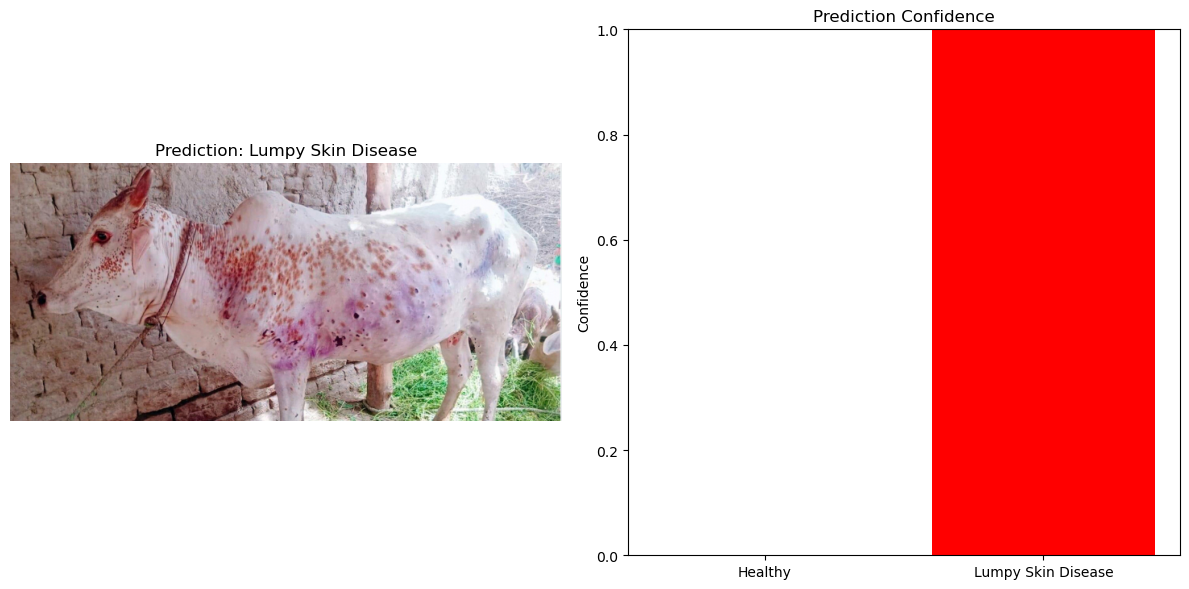

FileUpload(value={}, accept='image/*', description='Upload')

In [23]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
import io
from PIL import Image, ImageDraw, ImageFont

# Function to preprocess the uploaded image
def preprocess_image(image):
    """Resize, normalize, and expand dimensions of the image."""
    image_array = np.array(image)
    if image_array is None:
        raise ValueError("Image not loaded correctly.")
    
    image_resized = cv2.resize(image_array, (224, 224))
    image_normalized = preprocess_input(image_resized)
    return np.expand_dims(image_normalized, axis=0)

# Function to predict and visualize the results
def predict_and_display(image, model, label_encoder):
    """Predict if Lumpy Skin Disease is present in the uploaded image and display results."""
    try:
        image_preprocessed = preprocess_image(image)
        prediction = model.predict(image_preprocessed)[0][0]
        
        confidence = max(prediction, 1 - prediction)
        predicted_label = 'Healthy' if prediction < 0.5 else 'Lumpy Skin Disease'
        
        # Display results
        display_prediction(image, predicted_label, confidence)
    except Exception as e:
        print(f"Error during prediction: {e}")

# Function to display the prediction result on the image
def display_prediction(image, predicted_label, confidence):
    """Display the prediction label and confidence on the image."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display the result on the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    
    # Show the image in the first subplot
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title(f"Prediction: {predicted_label}")
    
    # Display a confidence bar chart in the second subplot
    labels = ['Healthy', 'Lumpy Skin Disease']
    confidence_values = [1 - confidence, confidence] if predicted_label == 'Lumpy Skin Disease' else [confidence, 1 - confidence]
    axes[1].bar(labels, confidence_values, color=['green', 'red'])
    axes[1].set_title("Prediction Confidence")
    axes[1].set_ylabel("Confidence")
    axes[1].set_ylim(0, 1)
    
    # Adjust layout and show the combined figure
    plt.tight_layout()
    plt.show()

# Function to handle the uploaded image file
def on_file_upload(change):
    """Handle image upload and invoke prediction."""
    clear_output(wait=True)
    
    for filename, file_info in change['new'].items():
        print(f"Uploaded file: {filename}")
        
        try:
            image = Image.open(io.BytesIO(file_info['content']))
            predict_and_display(image, model, label_encoder)
        except Exception as e:
            print(f"Error loading image: {e}")
    
    reset_file_upload_widget()

# Function to create and display the file upload widget
def reset_file_upload_widget():
    """Reset and display the file upload widget."""
    file_upload = widgets.FileUpload(
        accept='image/*',  # Accepts image files only
        multiple=False     # Allows single file upload, change to True to allow multiple files
    )
    file_upload.observe(on_file_upload, names='value')
    display(file_upload)

# Initially display the file upload widget
reset_file_upload_widget()
